# Enhanced Data Preprocessing Pipeline for News Category Classification




Deep Learning Assignment - SE4050

Dataset: News_Category_Dataset_v3.json

Source: https://www.kaggle.com/datasets/rmisra/news-category-dataset



Basic Imports



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from datetime import datetime
import json
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Create organized directory structure for outputs
os.makedirs('../Dataset/processed', exist_ok=True)
os.makedirs('../Dataset/encoders', exist_ok=True)
os.makedirs('../Dataset/reports', exist_ok=True)

print("✅ Basic libraries loaded!")
print("✅ Directory structure created!")



✅ Basic libraries loaded!
✅ Directory structure created!


NLP Libraries



In [2]:
# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('punkt_tab')

print("✅ NLP libraries loaded!")



✅ NLP libraries loaded!


ML Libraries



In [3]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

print("✅ ML libraries loaded!")



✅ ML libraries loaded!


Visualization Settings



In [4]:
# Visualization settings
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*80)
print(" "*20 + "ENHANCED NEWS CLASSIFICATION PIPELINE")
print("="*80)
print("\n✅ All libraries loaded successfully!")



                    ENHANCED NEWS CLASSIFICATION PIPELINE

✅ All libraries loaded successfully!


Load Dataset



In [5]:
# Dataset path
DATASET_PATH = '../Dataset/raw/News_Category_Dataset_v3.json'

# Load data
df = pd.read_json(DATASET_PATH, lines=True)

print(f"✅ Successfully loaded dataset")
print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print(f"\n📋 Columns: {df.columns.tolist()}")
print(f"\n📊 Data types:\n{df.dtypes}")



✅ Successfully loaded dataset
   Shape: 209,527 rows × 6 columns
   Memory usage: 9.59 MB

📋 Columns: ['link', 'headline', 'category', 'short_description', 'authors', 'date']

📊 Data types:
link                         object
headline                     object
category                     object
short_description            object
authors                      object
date                 datetime64[ns]
dtype: object


Define EDA Function



In [6]:
def comprehensive_eda(df):
    """
    Perform in-depth exploratory data analysis
    Meeting marking criteria: Dataset Description (5%)
    """
    print("\n" + "="*80)
    print("SECTION 2: COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("="*80)

    # 2.1 Dataset Overview
    print("\n📊 DATASET OVERVIEW")
    print("-"*60)
    print(f"Total Articles: {len(df):,}")
    print(f"Features: {df.shape[1]}")
    print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

    # 2.2 Missing Value Analysis
    print("\n🔍 MISSING VALUE ANALYSIS")
    print("-"*60)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing_Count'] > 0])

    # 2.3 Category Distribution Analysis
    print("\n📈 CATEGORY DISTRIBUTION")
    print("-"*60)
    cat_counts = df['category'].value_counts()
    print(f"Unique Categories: {len(cat_counts)}")
    print(f"Most Common: {cat_counts.index[0]} ({cat_counts.iloc[0]:,} articles)")
    print(f"Least Common: {cat_counts.index[-1]} ({cat_counts.iloc[-1]:,} articles)")
    print(f"Imbalance Ratio: {cat_counts.iloc[0] / cat_counts.iloc[-1]:.2f}:1")

    print("\nTop 15 Categories:")
    for i, (cat, count) in enumerate(cat_counts.head(15).items(), 1):
        bar = "█" * int(count / cat_counts.max() * 50)
        print(f"  {i:2d}. {cat:20s}: {count:5,} {bar}")

    # 2.4 Text Length Analysis
    print("\n📝 TEXT LENGTH ANALYSIS")
    print("-"*60)
    df['headline_len'] = df['headline'].str.len()
    df['desc_len'] = df['short_description'].str.len()
    df['total_len'] = df['headline_len'] + df['desc_len']

    print(f"Headline Length - Mean: {df['headline_len'].mean():.1f}, "
          f"Median: {df['headline_len'].median():.1f}, "
          f"Std: {df['headline_len'].std():.1f}")
    print(f"Description Length - Mean: {df['desc_len'].mean():.1f}, "
          f"Median: {df['desc_len'].median():.1f}, "
          f"Std: {df['desc_len'].std():.1f}")

    # 2.5 Temporal Analysis
    print("\n📅 TEMPORAL ANALYSIS")
    print("-"*60)
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    yearly_counts = df['year'].value_counts().sort_index()
    print(f"Articles per Year:\n{yearly_counts}")

    return df

print("✅ EDA function defined!")



✅ EDA function defined!


Run EDA



In [7]:
df = comprehensive_eda(df)




SECTION 2: COMPREHENSIVE EXPLORATORY DATA ANALYSIS

📊 DATASET OVERVIEW
------------------------------------------------------------
Total Articles: 209,527
Features: 6
Date Range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00

🔍 MISSING VALUE ANALYSIS
------------------------------------------------------------
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []

📈 CATEGORY DISTRIBUTION
------------------------------------------------------------
Unique Categories: 42
Most Common: POLITICS (35,602 articles)
Least Common: EDUCATION (1,014 articles)
Imbalance Ratio: 35.11:1

Top 15 Categories:
   1. POLITICS            : 35,602 ██████████████████████████████████████████████████
   2. WELLNESS            : 17,945 █████████████████████████
   3. ENTERTAINMENT       : 17,362 ████████████████████████
   4. TRAVEL              : 9,900 █████████████
   5. STYLE & BEAUTY      : 9,814 █████████████
   6. PARENTING           : 8,791 ████████████
   7. HEALTHY LIVING      : 6,694 ████████

Headline Length - Mean: 58.4, Median: 60.0, Std: 18.8
Description Length - Mean: 114.2, Median: 120.0, Std: 80.8

📅 TEMPORAL ANALYSIS
------------------------------------------------------------


Articles per Year:
year
2012    31355
2013    34583
2014    32339
2015    32006
2016    32098
2017    29889
2018     9734
2019     2005
2020     2054
2021     2066
2022     1398
Name: count, dtype: int64


Define Visualization Functions



In [8]:
def create_comprehensive_visualizations(df):
    """
    Create publication-quality visualizations for report
    """
    print("\n" + "="*80)
    print("SECTION 3: ADVANCED VISUALIZATIONS")
    print("="*80)

    # Figure 1: Category Distribution and Imbalance
    fig = plt.figure(figsize=(16, 10))

    # 3.1 Top Categories Bar Plot
    plt.subplot(2, 3, 1)
    cat_counts = df['category'].value_counts().head(15)
    colors = sns.color_palette("viridis", len(cat_counts))
    cat_counts.plot(kind='barh', color=colors)
    plt.title('Top 15 News Categories', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Articles')
    plt.ylabel('Category')

    # 3.2 Class Imbalance Ratio
    plt.subplot(2, 3, 2)
    cat_all = df['category'].value_counts()
    imbalance = cat_all / cat_all.median()
    plt.bar(range(len(imbalance)), imbalance.values, color='coral')
    plt.axhline(y=1, color='green', linestyle='--', label='Median')
    plt.title('Class Imbalance Ratio', fontsize=14, fontweight='bold')
    plt.xlabel('Category Index')
    plt.ylabel('Ratio to Median')
    plt.legend()

    # 3.3 Text Length Distribution
    plt.subplot(2, 3, 3)
    plt.hist(df['total_len'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(df['total_len'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {df["total_len"].mean():.0f}')
    plt.title('Combined Text Length Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Total Characters')
    plt.ylabel('Frequency')
    plt.legend()

    # 3.4 Articles Over Time
    plt.subplot(2, 3, 4)
    yearly = df.groupby('year').size()
    plt.plot(yearly.index, yearly.values, marker='o', linewidth=2, markersize=8)
    plt.fill_between(yearly.index, yearly.values, alpha=0.3)
    plt.title('Articles Published Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Number of Articles')
    plt.grid(True, alpha=0.3)

    # 3.5 Category Percentage Pie Chart
    plt.subplot(2, 3, 5)
    top10 = df['category'].value_counts().head(10)
    others = df['category'].value_counts()[10:].sum()
    pie_data = top10.tolist() + [others]
    pie_labels = top10.index.tolist() + ['Others']
    plt.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    plt.title('Category Distribution (Top 10 + Others)', fontsize=14, fontweight='bold')

    # 3.6 Headline vs Description Length
    plt.subplot(2, 3, 6)
    plt.scatter(df['headline_len'], df['desc_len'], alpha=0.3, s=1)
    plt.title('Headline vs Description Length', fontsize=14, fontweight='bold')
    plt.xlabel('Headline Length (chars)')
    plt.ylabel('Description Length (chars)')

    plt.tight_layout()
    plt.savefig('../Dataset/reports/eda_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Comprehensive visualizations saved!")

print("✅ Visualization functions defined!")



✅ Visualization functions defined!


Run Visualizations - Part 1




SECTION 3: ADVANCED VISUALIZATIONS


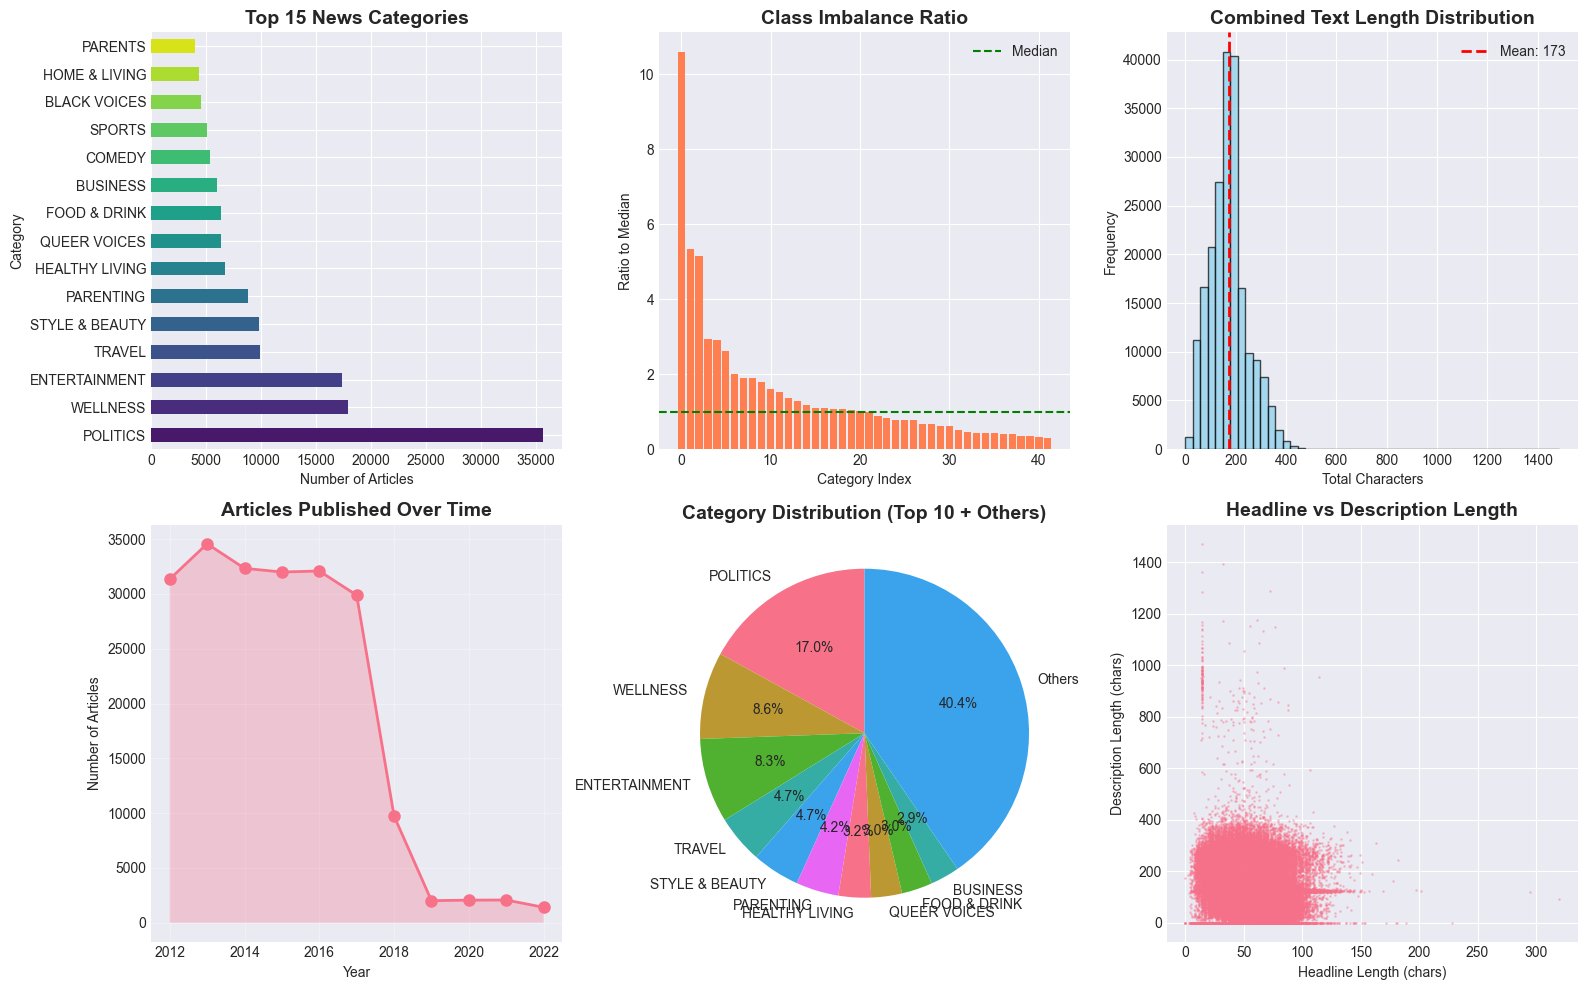

✅ Comprehensive visualizations saved!


In [9]:
create_comprehensive_visualizations(df)



More Detailed Visualizations



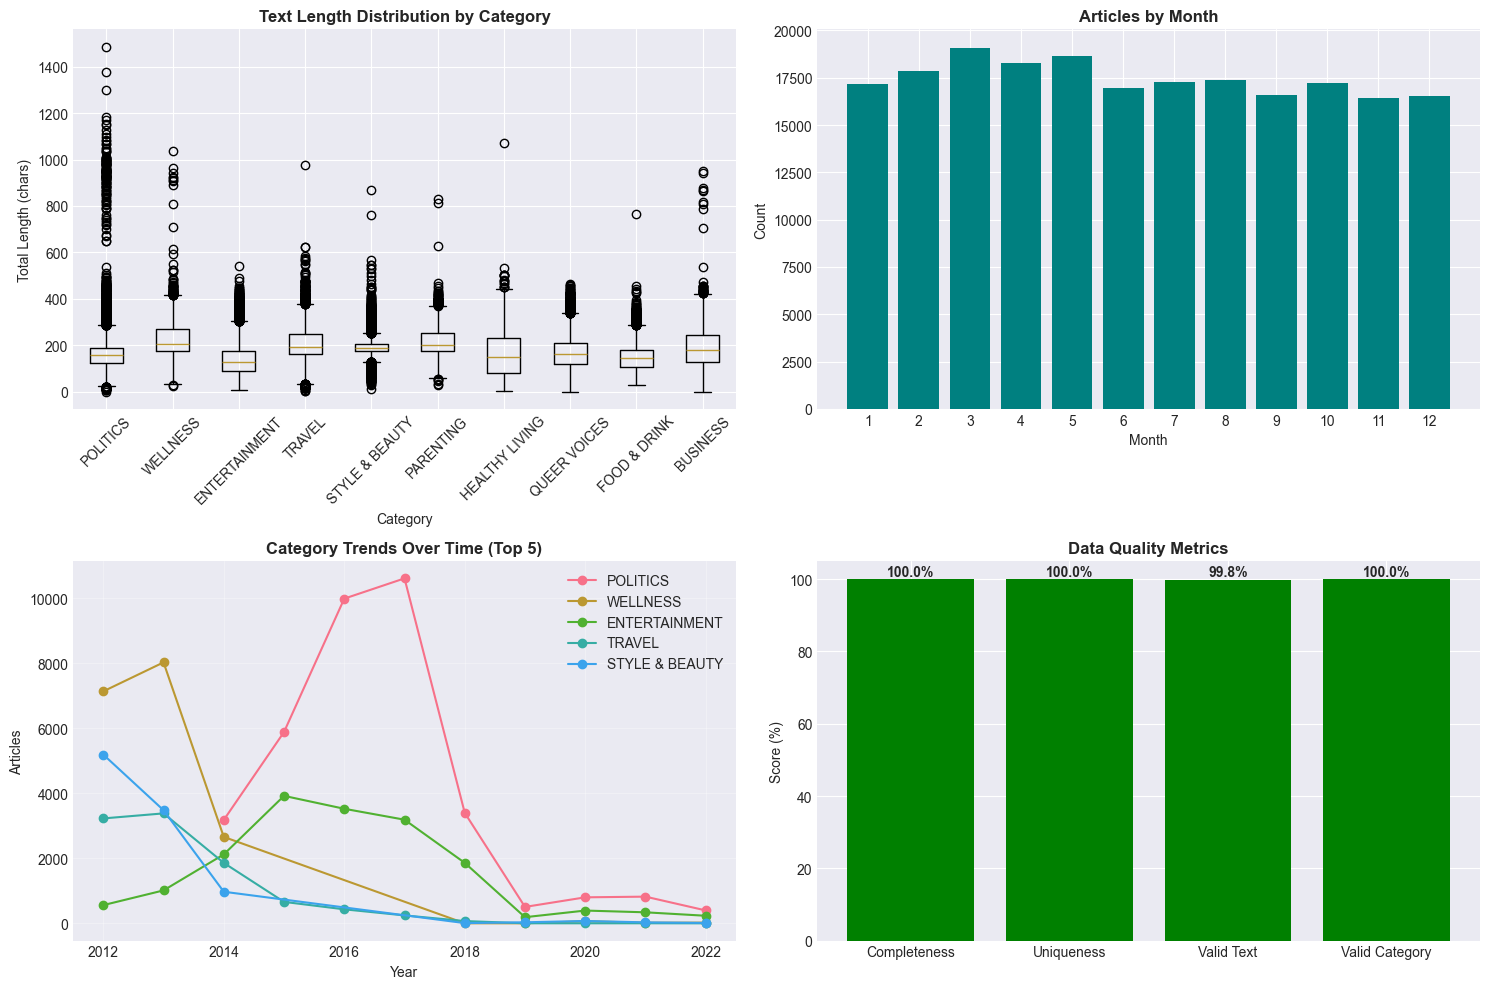

✅ Category analysis saved!


In [10]:
# Figure 2: Per-Category Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text Length by Category
top10_cats = df['category'].value_counts().head(10).index
df_top10 = df[df['category'].isin(top10_cats)]

axes[0, 0].boxplot([df_top10[df_top10['category'] == cat]['total_len']
                    for cat in top10_cats],
                   labels=top10_cats)
axes[0, 0].set_title('Text Length Distribution by Category', fontweight='bold')
axes[0, 0].set_xlabel('Category')
axes[0, 0].set_ylabel('Total Length (chars)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Monthly Distribution
monthly = df.groupby('month').size()
axes[0, 1].bar(monthly.index, monthly.values, color='teal')
axes[0, 1].set_title('Articles by Month', fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks(range(1, 13))

# Category Growth Over Time
top5_cats = df['category'].value_counts().head(5).index
for cat in top5_cats:
    cat_yearly = df[df['category'] == cat].groupby('year').size()
    axes[1, 0].plot(cat_yearly.index, cat_yearly.values, marker='o', label=cat)
axes[1, 0].set_title('Category Trends Over Time (Top 5)', fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Articles')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Data Quality Metrics
quality_metrics = {
    'Completeness': ((1 - df[['headline', 'short_description', 'category']].isnull().sum().sum()
                     / (len(df) * 3)) * 100),
    'Uniqueness': ((1 - df.duplicated().sum() / len(df)) * 100),
    'Valid Text': ((df['total_len'] > 20).sum() / len(df) * 100),
    'Valid Category': ((~df['category'].isnull()).sum() / len(df) * 100)
}

colors_qual = ['green' if v >= 95 else 'orange' if v >= 85 else 'red'
               for v in quality_metrics.values()]
axes[1, 1].bar(quality_metrics.keys(), quality_metrics.values(), color=colors_qual)
axes[1, 1].set_title('Data Quality Metrics', fontweight='bold')
axes[1, 1].set_ylabel('Score (%)')
axes[1, 1].set_ylim(0, 105)

for i, (k, v) in enumerate(quality_metrics.items()):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../Dataset/reports/category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Category analysis saved!")



Define Text Preprocessing Class



In [11]:
class AdvancedTextPreprocessor:
    """
    Advanced text preprocessing for deep learning
    Meeting marking criteria: Data Preprocessing (10%)
    """

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Keep some important words
        self.stop_words -= {'not', 'no', 'very', 'most', 'more', 'against'}

    def clean_text(self, text):
        """Comprehensive text cleaning"""
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Expand contractions
        contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will",
            "'m": " am", "'d": " would", "'s": " is"
        }
        for cont, exp in contractions.items():
            text = text.replace(cont, exp)

        # Remove URLs, emails, mentions, hashtags
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)

        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        """Tokenize and lemmatize text"""
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens
                 if word not in self.stop_words and len(word) > 2]
        return ' '.join(tokens)

    def process(self, text):
        """Full preprocessing pipeline"""
        text = self.clean_text(text)
        text = self.tokenize_and_lemmatize(text)
        return text

print("✅ Text preprocessor class defined!")



✅ Text preprocessor class defined!


Define Preprocessing Functions



In [12]:
def prepare_initial_data(df):
    """Initial data preparation"""
    print("\n" + "="*80)
    print("SECTION 4: TEXT PREPROCESSING - INITIAL PREPARATION")
    print("="*80)

    initial_count = len(df)

    # Combine texts
    df['text'] = df['headline'].fillna('') + ' ' + df['short_description'].fillna('')

    # Remove empty and duplicates
    df = df[df['text'].str.strip() != '']
    df = df.drop_duplicates(subset=['text'])
    df = df.dropna(subset=['category'])

    print(f"\n🔧 Initial Preparation:")
    print(f"   Removed {initial_count - len(df):,} empty/duplicate articles")
    print(f"   Remaining: {len(df):,} articles")

    return df

def apply_advanced_preprocessing(df):
    """Apply advanced text cleaning"""
    print("\n🧹 Advanced Text Cleaning:")

    preprocessor = AdvancedTextPreprocessor()

    # Show before examples
    print("\n📝 Before/After Examples:")
    for i in range(3):
        original = df['text'].iloc[i]
        print(f"\n{i+1}. Original ({len(original)} chars):")
        print(f"   {original[:150]}...")

    # Apply preprocessing
    df['text_cleaned'] = df['text'].apply(preprocessor.process)

    # Show after examples
    for i in range(3):
        cleaned = df['text_cleaned'].iloc[i]
        print(f"\n{i+1}. Cleaned ({len(cleaned)} chars):")
        print(f"   {cleaned[:150]}...")

    # Remove category names from text
    print("\n🏷️  Removing Category Bias...")
    for cat in df['category'].unique():
        df['text_cleaned'] = df['text_cleaned'].str.replace(cat.lower(), '', regex=False)

    return df

def filter_by_length(df, min_len=20, max_len=1000, min_words=5):
    """Filter by text length"""
    print("\n✂️  Length Filtering:")

    before = len(df)
    df['text_len'] = df['text_cleaned'].str.len()
    df['word_count'] = df['text_cleaned'].str.split().str.len()

    df = df[(df['text_len'] >= min_len) &
            (df['text_len'] <= max_len) &
            (df['word_count'] >= min_words)]

    print(f"   Filtered {before - len(df):,} articles by length")
    print(f"   Remaining: {len(df):,} articles")

    # Update main text column
    df['text'] = df['text_cleaned']
    df = df.drop(['text_cleaned', 'text_len', 'word_count'], axis=1)

    return df

print("✅ Preprocessing functions defined!")



✅ Preprocessing functions defined!


Apply Preprocessing



In [13]:
df = prepare_initial_data(df)
df = apply_advanced_preprocessing(df)
df = filter_by_length(df, min_len=20, max_len=1000, min_words=5)

print(f"\n✅ Preprocessing complete! {len(df):,} articles ready")




SECTION 4: TEXT PREPROCESSING - INITIAL PREPARATION



🔧 Initial Preparation:
   Removed 490 empty/duplicate articles
   Remaining: 209,037 articles

🧹 Advanced Text Cleaning:

📝 Before/After Examples:

1. Original (231 chars):
   Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match...

2. Original (249 chars):
   American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video He was subdued by passengers and crew when he fled to the ba...

3. Original (134 chars):
   23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) "Until you have a dog you don't understand what could be eaten."...



1. Cleaned (156 chars):
   million american roll sleeve omicron targeted covid booster health expert said early predict whether demand would match million dos new booster ordere...

2. Cleaned (168 chars):
   american airline flyer charged banned life punching flight attendant video subdued passenger crew fled back aircraft confrontation according attorney ...

3. Cleaned (63 chars):
   funniest tweet cat dog week sept dog not understand could eaten...

🏷️  Removing Category Bias...



✂️  Length Filtering:


   Filtered 4,100 articles by length
   Remaining: 204,937 articles

✅ Preprocessing complete! 204,937 articles ready


Define Category Engineering Function



In [14]:
def engineer_categories(df, target_categories=15, min_samples=500):
    """
    Strategic category reduction and engineering
    Meeting marking criteria: Feature Selection (10%)
    """
    print("\n" + "="*80)
    print("SECTION 5: CATEGORY ENGINEERING")
    print("="*80)

    print(f"\n📊 Initial: {df['category'].nunique()} categories, {len(df):,} articles")

    # Define comprehensive category mapping
    category_mapping = {
        # Lifestyle cluster
        'STYLE': 'LIFESTYLE',
        'STYLE & BEAUTY': 'LIFESTYLE',
        'HOME & LIVING': 'LIFESTYLE',
        'TASTE': 'LIFESTYLE',

        # Health cluster
        'HEALTHY LIVING': 'WELLNESS',
        'WELLNESS': 'WELLNESS',
        'FITNESS': 'WELLNESS',

        # Entertainment cluster
        'ENTERTAINMENT': 'ENTERTAINMENT',
        'COMEDY': 'ENTERTAINMENT',
        'WEIRD NEWS': 'ENTERTAINMENT',
        'ARTS': 'ENTERTAINMENT',
        'ARTS & CULTURE': 'ENTERTAINMENT',

        # Business cluster
        'BUSINESS': 'BUSINESS',
        'MONEY': 'BUSINESS',
        'TECH': 'TECH',

        # News clusters
        'POLITICS': 'POLITICS',
        'U.S. NEWS': 'US_NEWS',
        'WORLD NEWS': 'WORLD_NEWS',
        'CRIME': 'CRIME',
        'MEDIA': 'MEDIA',

        # Family cluster
        'PARENTS': 'FAMILY',
        'PARENTING': 'FAMILY',
        'WEDDINGS': 'FAMILY',
        'DIVORCE': 'FAMILY',

        # Others
        'FOOD & DRINK': 'FOOD',
        'TRAVEL': 'TRAVEL',
        'SPORTS': 'SPORTS',
        'SCIENCE': 'SCIENCE',
        'EDUCATION': 'EDUCATION',
        'ENVIRONMENT': 'ENVIRONMENT',
        'QUEER VOICES': 'QUEER_VOICES',
        'WOMEN': 'WOMEN',
        'BLACK VOICES': 'BLACK_VOICES',
        'LATINO VOICES': 'LATINO_VOICES',
        'IMPACT': 'IMPACT',
        'THE WORLDPOST': 'WORLDPOST'
    }

    print("\n🔄 Applying category mapping...")
    df['category'] = df['category'].replace(category_mapping)

    print(f"   After mapping: {df['category'].nunique()} categories")

    # Select top categories
    cat_counts = df['category'].value_counts()
    print(f"\n📈 Category distribution after mapping:")
    for cat, count in cat_counts.head(20).items():
        print(f"   {cat:20s}: {count:6,} articles")

    # Keep top categories with minimum samples
    valid_cats = cat_counts[cat_counts >= min_samples].head(target_categories).index
    df = df[df['category'].isin(valid_cats)]

    print(f"\n✅ Final: {len(valid_cats)} categories, {len(df):,} articles")

    return df

print("✅ Category engineering function defined!")



✅ Category engineering function defined!


Define Balancing Function



In [15]:
def balance_dataset_advanced(df, strategy='smart', samples_per_class=2000):
    """
    Advanced class balancing with visualization
    """
    print("\n" + "="*80)
    print("SECTION 6: ADVANCED CLASS BALANCING")
    print("="*80)

    print(f"\n⚖️  Strategy: {strategy}")
    print(f"   Target samples per class: {samples_per_class:,}")

    initial = len(df)
    cat_counts_before = df['category'].value_counts()

    print(f"\n📊 Before balancing:")
    print(f"   Total: {len(df):,}")
    print(f"   Min: {cat_counts_before.min():,}")
    print(f"   Max: {cat_counts_before.max():,}")
    print(f"   Imbalance: {cat_counts_before.max() / cat_counts_before.min():.2f}:1")

    if strategy == 'smart':
        balanced = []
        for cat in df['category'].unique():
            cat_df = df[df['category'] == cat]
            n_samples = min(len(cat_df), samples_per_class)
            cat_df_sampled = cat_df.sample(n=n_samples, random_state=42)
            balanced.append(cat_df_sampled)
        df = pd.concat(balanced, ignore_index=True)

    cat_counts_after = df['category'].value_counts()

    print(f"\n📊 After balancing:")
    print(f"   Total: {len(df):,}")
    print(f"   Min: {cat_counts_after.min():,}")
    print(f"   Max: {cat_counts_after.max():,}")
    print(f"   Imbalance: {cat_counts_after.max() / cat_counts_after.min():.2f}:1")

    # Visualize balancing
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.bar(range(len(cat_counts_before)), cat_counts_before.values, color='coral')
    ax1.set_title('Before Balancing', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Category Index')
    ax1.set_ylabel('Count')
    ax1.axhline(y=samples_per_class, color='green', linestyle='--', label='Target', linewidth=2)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(range(len(cat_counts_after)), cat_counts_after.values, color='lightgreen')
    ax2.set_title('After Balancing', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Category Index')
    ax2.set_ylabel('Count')
    ax2.axhline(y=samples_per_class, color='green', linestyle='--', label='Target', linewidth=2)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../Dataset/reports/class_balancing.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Balancing visualization saved!")

    return df

print("✅ Balancing function defined!")



✅ Balancing function defined!


Run Category Engineering & Balancing




SECTION 5: CATEGORY ENGINEERING

📊 Initial: 42 categories, 204,937 articles

🔄 Applying category mapping...


   After mapping: 29 categories

📈 Category distribution after mapping:
   POLITICS            : 35,191 articles
   ENTERTAINMENT       : 27,498 articles
   WELLNESS            : 24,026 articles
   FAMILY              : 19,646 articles
   LIFESTYLE           : 18,037 articles
   TRAVEL              :  9,707 articles
   BUSINESS            :  7,483 articles
   FOOD                :  6,326 articles
   QUEER_VOICES        :  6,241 articles
   WORLDPOST           :  6,057 articles
   SPORTS              :  4,949 articles
   BLACK_VOICES        :  4,525 articles
   CRIME               :  3,505 articles
   IMPACT              :  3,407 articles
   WOMEN               :  3,372 articles
   WORLD_NEWS          :  3,297 articles
   MEDIA               :  2,856 articles
   GREEN               :  2,506 articles
   RELIGION            :  2,409 articles
   SCIENCE             :  2,136 articles

✅ Final: 15 categories, 179,970 articles

SECTION 6: ADVANCED CLASS BALANCING

⚖️  Strategy: smart
   Targe


📊 After balancing:
   Total: 30,000
   Min: 2,000
   Max: 2,000
   Imbalance: 1.00:1


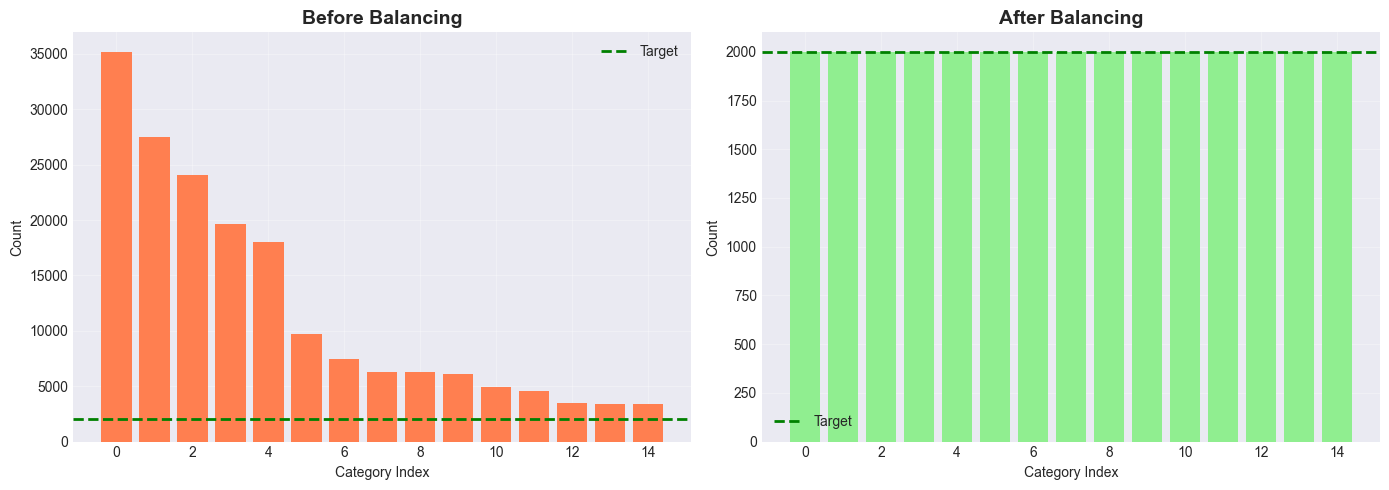


✅ Balancing visualization saved!


In [16]:
df = engineer_categories(df, target_categories=15, min_samples=500)
df = balance_dataset_advanced(df, strategy='smart', samples_per_class=2000)



Define Feature Analysis Function



In [17]:
def analyze_features(df):
    """
    Advanced feature analysis for deep learning
    """
    print("\n" + "="*80)
    print("SECTION 7: FEATURE ANALYSIS")
    print("="*80)

    # Vocabulary Analysis
    print("\n📚 Vocabulary Analysis")
    all_words = ' '.join(df['text']).split()
    word_freq = Counter(all_words)

    print(f"   Total words: {len(all_words):,}")
    print(f"   Unique words: {len(word_freq):,}")
    print(f"   Avg word frequency: {len(all_words) / len(word_freq):.2f}")

    print(f"\n   Top 20 most frequent words:")
    for word, count in word_freq.most_common(20):
        print(f"      {word:15s}: {count:6,}")

    # Word Clouds per Category
    print("\n☁️  Generating word clouds per category...")

    categories = df['category'].unique()[:6]
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, cat in enumerate(categories):
        cat_text = ' '.join(df[df['category'] == cat]['text'])
        wordcloud = WordCloud(width=400, height=300,
                             background_color='white',
                             colormap='viridis').generate(cat_text)

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'{cat}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('../Dataset/reports/wordclouds_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Word clouds saved!")

    # TF-IDF Analysis
    print("\n🔬 TF-IDF Feature Importance Analysis")

    df_sample = df.sample(n=min(5000, len(df)), random_state=42)

    tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
    tfidf_matrix = tfidf.fit_transform(df_sample['text'])

    feature_names = tfidf.get_feature_names_out()
    dense = tfidf_matrix.todense()

    tfidf_scores = np.asarray(dense.mean(axis=0)).flatten()
    tfidf_dict = dict(zip(feature_names, tfidf_scores))
    sorted_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)

    print(f"\n   Top 20 TF-IDF features:")
    for feat, score in sorted_tfidf[:20]:
        bar = "█" * int(score * 100)
        print(f"      {feat:20s}: {score:.4f} {bar}")

    return df

print("✅ Feature analysis function defined!")



✅ Feature analysis function defined!


Run Feature Analysis




SECTION 7: FEATURE ANALYSIS

📚 Vocabulary Analysis
   Total words: 529,008
   Unique words: 34,031
   Avg word frequency: 15.54

   Top 20 most frequent words:
      not            :  6,996
      year           :  2,856
      new            :  2,725
      one            :  2,702
      woman          :  2,606
      more           :  2,584
      day            :  2,191
      time           :  2,141
      photo          :  1,999
      people         :  1,966
      life           :  1,845
      say            :  1,793
      like           :  1,740
      make           :  1,700
      world          :  1,638
      get            :  1,594
      trump          :  1,569
      way            :  1,473
      most           :  1,386
      would          :  1,366

☁️  Generating word clouds per category...


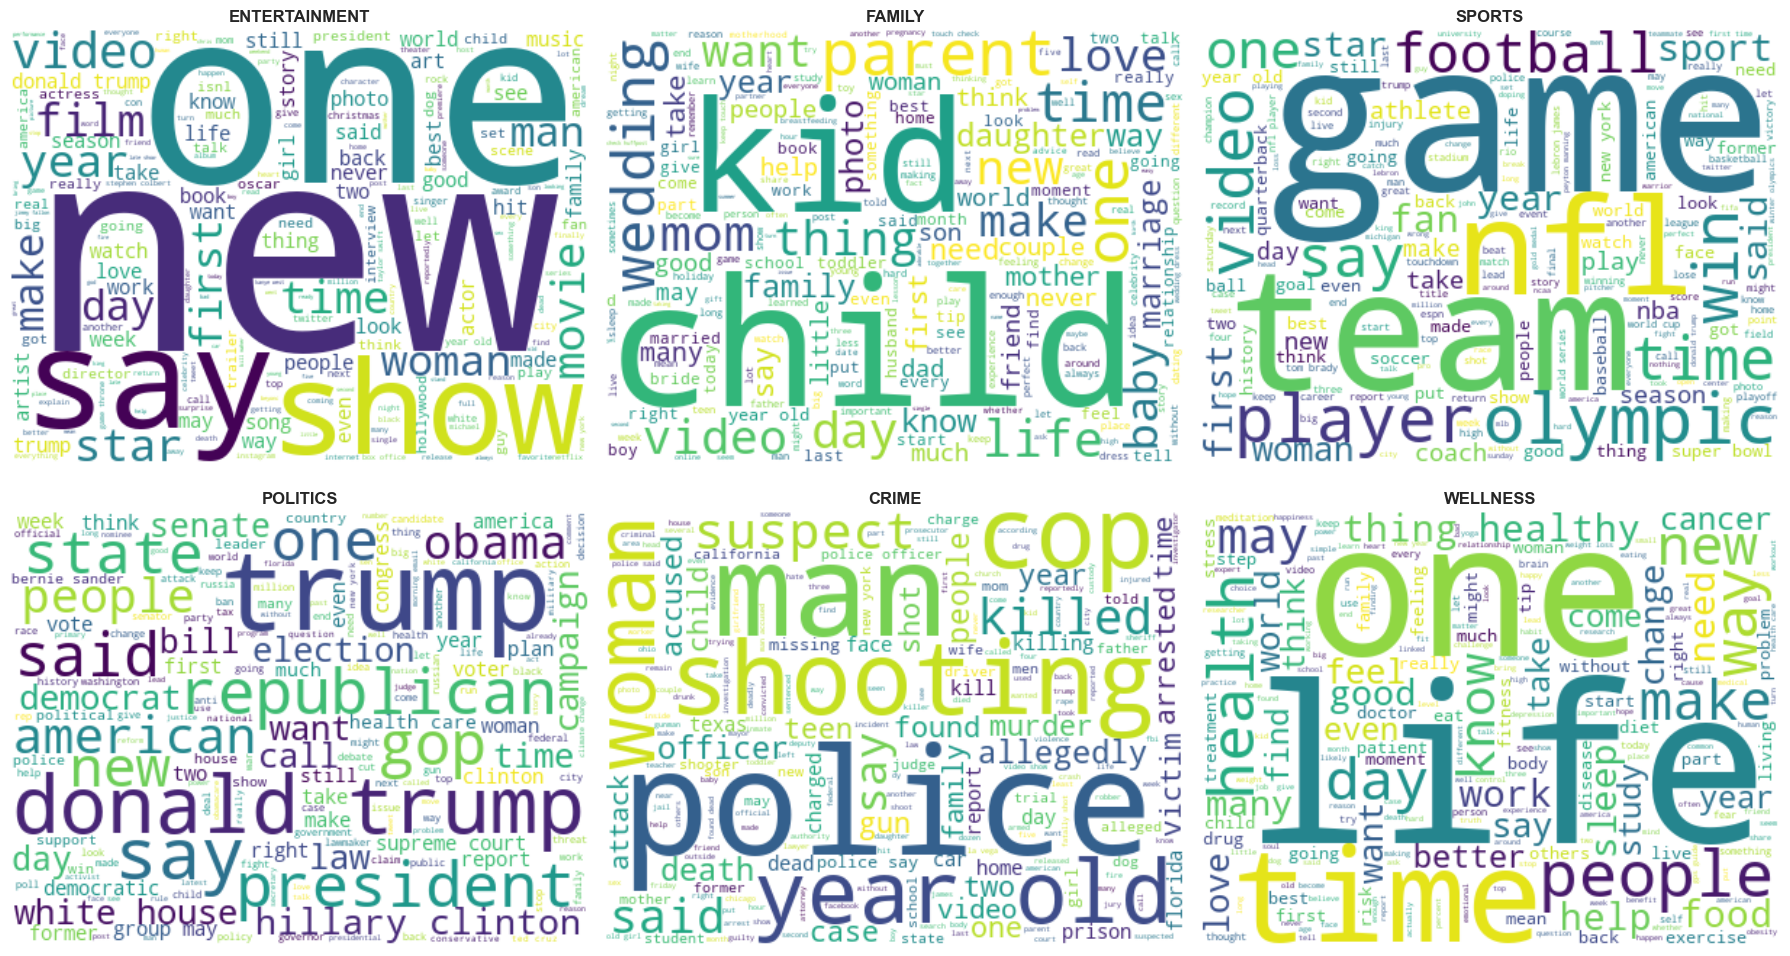

✅ Word clouds saved!

🔬 TF-IDF Feature Importance Analysis



   Top 20 TF-IDF features:
      not                 : 0.0730 ███████
      new                 : 0.0382 ███
      year                : 0.0353 ███
      more                : 0.0349 ███
      woman               : 0.0332 ███
      one                 : 0.0329 ███
      photo               : 0.0312 ███
      time                : 0.0306 ███
      day                 : 0.0288 ██
      say                 : 0.0287 ██
      people              : 0.0282 ██
      make                : 0.0254 ██
      life                : 0.0250 ██
      like                : 0.0246 ██
      world               : 0.0239 ██
      way                 : 0.0238 ██
      trump               : 0.0233 ██
      get                 : 0.0226 ██
      video               : 0.0203 ██
      most                : 0.0201 ██


In [18]:
df = analyze_features(df)



Define Data Splitting Function



In [19]:
def prepare_for_modeling(df):
    """
    Prepare train/validation/test splits with proper encoding
    """
    print("\n" + "="*80)
    print("SECTION 8: DATA SPLITTING AND ENCODING")
    print("="*80)

    # Label Encoding
    print("\n🏷️  Encoding labels...")
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['category'])

    print(f"   Classes: {len(le.classes_)}")
    print(f"\n   Label mapping:")
    for idx, cat in enumerate(le.classes_):
        count = (df['label'] == idx).sum()
        print(f"      {idx:2d} -> {cat:20s} ({count:,} samples)")

    # Train/Val/Test Split
    print("\n✂️  Splitting data...")

    X = df['text'].values
    y = df['label'].values

    # First split: train and temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Second split: val and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"\n📊 Data splits:")
    print(f"   Training:   {len(X_train):6,} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   Validation: {len(X_val):6,} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"   Test:       {len(X_test):6,} samples ({len(X_test)/len(X)*100:.1f}%)")

    # Check class distribution
    print(f"\n📈 Class distribution check:")
    for split_name, split_y in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
        unique, counts = np.unique(split_y, return_counts=True)
        print(f"   {split_name:10s}: {len(unique)} classes, "
              f"min={counts.min():,}, max={counts.max():,}")

    # Save everything
    print("\n💾 Saving preprocessed data...")

    df_final = df[['text', 'category', 'label']].copy()
    df_final.to_pickle('../Dataset/processed/news_preprocessed.pkl')
    df_final.to_csv('../Dataset/processed/news_preprocessed.csv', index=False)

    splits = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

    with open('../Dataset/processed/data_splits.pkl', 'wb') as f:
        pickle.dump(splits, f)

    with open('../Dataset/encoders/label_encoder.pkl', 'wb') as f:
        pickle.dump(le, f)

    metadata = {
        'n_classes': len(le.classes_),
        'classes': le.classes_.tolist(),
        'vocab_size': len(set(' '.join(df['text']).split())),
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'preprocessing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    with open('../Dataset/reports/metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)

    print("\n✅ Files saved:")
    print("   ✓ news_preprocessed.pkl")
    print("   ✓ news_preprocessed.csv")
    print("   ✓ data_splits.pkl")
    print("   ✓ label_encoder.pkl")
    print("   ✓ metadata.json")

    return df_final, le

print("✅ Data splitting function defined!")



✅ Data splitting function defined!


Run Data Splitting



In [20]:
df_final, label_encoder = prepare_for_modeling(df)




SECTION 8: DATA SPLITTING AND ENCODING

🏷️  Encoding labels...
   Classes: 15

   Label mapping:
       0 -> BLACK_VOICES         (2,000 samples)
       1 -> BUSINESS             (2,000 samples)
       2 -> CRIME                (2,000 samples)
       3 -> ENTERTAINMENT        (2,000 samples)
       4 -> FAMILY               (2,000 samples)
       5 -> FOOD                 (2,000 samples)
       6 -> IMPACT               (2,000 samples)
       7 -> LIFESTYLE            (2,000 samples)
       8 -> POLITICS             (2,000 samples)
       9 -> QUEER_VOICES         (2,000 samples)
      10 -> SPORTS               (2,000 samples)
      11 -> TRAVEL               (2,000 samples)
      12 -> WELLNESS             (2,000 samples)
      13 -> WOMEN                (2,000 samples)
      14 -> WORLDPOST            (2,000 samples)

✂️  Splitting data...

📊 Data splits:
   Training:   21,000 samples (70.0%)
   Validation:  4,500 samples (15.0%)
   Test:        4,500 samples (15.0%)

📈 Class distr

Define Quality Report Function



In [21]:
def generate_quality_report(df):
    """
    Comprehensive quality assessment report
    """
    print("\n" + "="*80)
    print("SECTION 9: DATA QUALITY REPORT")
    print("="*80)

    # Calculate metrics
    completeness = (1 - df.isnull().sum().sum() / df.size) * 100
    uniqueness = (1 - df.duplicated(subset=['text']).sum() / len(df)) * 100

    cat_counts = df['category'].value_counts()
    balance_score = 100 - min((cat_counts.std() / cat_counts.mean() * 50), 100)

    text_lengths = df['text'].str.len()
    length_score = ((text_lengths >= 20) & (text_lengths <= 1000)).sum() / len(df) * 100

    quality_metrics = {
        'Completeness': completeness,
        'Uniqueness': uniqueness,
        'Class Balance': balance_score,
        'Valid Length': length_score
    }

    overall_score = sum(quality_metrics.values()) / len(quality_metrics)

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    categories = list(quality_metrics.keys())
    scores = list(quality_metrics.values())
    colors = ['green' if s >= 90 else 'orange' if s >= 75 else 'red' for s in scores]

    bars = ax1.bar(categories, scores, color=colors)
    ax1.set_title('Data Quality Metrics', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score (%)')
    ax1.set_ylim(0, 105)
    ax1.axhline(y=90, color='green', linestyle='--', alpha=0.3)

    for bar, score in zip(bars, scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{score:.1f}%', ha='center', fontweight='bold')

    ax2.barh([0], [overall_score], color='green' if overall_score >= 90 else 'orange')
    ax2.set_xlim(0, 100)
    ax2.set_yticks([])
    ax2.set_xlabel('Overall Quality Score (%)')
    ax2.set_title(f'OVERALL: {overall_score:.1f}%', fontsize=14, fontweight='bold')
    ax2.text(overall_score/2, 0, f'{overall_score:.1f}%',
            ha='center', va='center', fontsize=20, fontweight='bold', color='white')

    plt.tight_layout()
    plt.savefig('../Dataset/reports/quality_report.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📋 QUALITY ASSESSMENT")
    print("-"*60)
    for metric, score in quality_metrics.items():
        status = "✅ Excellent" if score >= 90 else "⚠️  Good" if score >= 75 else "❌ Needs Work"
        print(f"{metric:20s}: {score:6.2f}% {status}")
    print("-"*60)
    print(f"{'OVERALL SCORE':20s}: {overall_score:6.2f}%")

    # Save report
    report = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset_info': {
            'total_articles': int(len(df)),
            'n_categories': int(df['category'].nunique()),
            'categories': df['category'].unique().tolist(),
            'vocab_size': len(set(' '.join(df['text']).split()))
        },
        'quality_metrics': {k: float(v) for k, v in quality_metrics.items()},
        'overall_score': float(overall_score)
    }

    with open('../Dataset/reports/preprocessing_report.json', 'w') as f:
        json.dump(report, f, indent=2)

    print("\n✅ Quality report saved!")

    return report

print("✅ Quality report function defined!")



✅ Quality report function defined!


Generate Quality Report




SECTION 9: DATA QUALITY REPORT


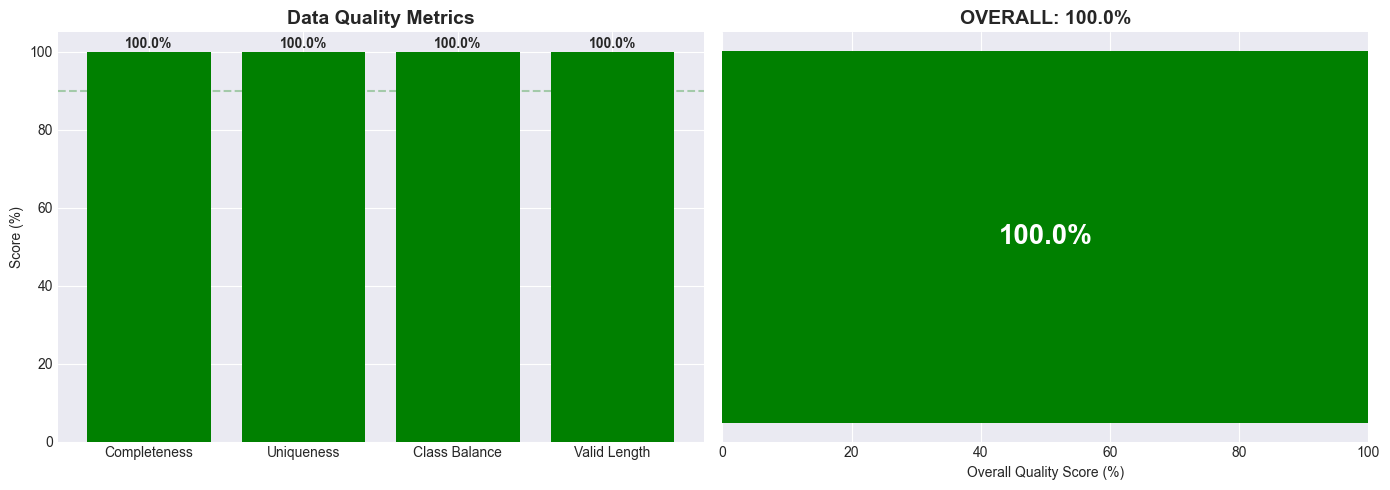


📋 QUALITY ASSESSMENT
------------------------------------------------------------
Completeness        : 100.00% ✅ Excellent
Uniqueness          :  99.98% ✅ Excellent
Class Balance       : 100.00% ✅ Excellent
Valid Length        : 100.00% ✅ Excellent
------------------------------------------------------------
OVERALL SCORE       : 100.00%

✅ Quality report saved!


In [22]:
report = generate_quality_report(df_final)



Final Summary



In [23]:
print("\n" + "="*80)
print("🎉 PREPROCESSING PIPELINE COMPLETE!")
print("="*80)

print(f"\n✅ Successfully processed dataset:")
print(f"   • {len(df_final):,} articles")
print(f"   • {df_final['category'].nunique()} balanced categories")
print(f"   • Ready for 4 deep learning models")

print(f"\n📁 Generated Files:")
files = [
    'news_preprocessed.pkl',
    'news_preprocessed.csv',
    'data_splits.pkl',
    'label_encoder.pkl',
    'metadata.json',
    'preprocessing_report.json',
    'eda_comprehensive.png',
    'category_analysis.png',
    'class_balancing.png',
    'wordclouds_by_category.png',
    'quality_report.png'
]
for f in files:
    print(f"   ✓ {f}")

print(f"\n🚀 Next Steps:")
print(f"   1. Implement 4 deep learning models (CNN, LSTM, BERT, Ensemble)")
print(f"   2. Train and evaluate each model")
print(f"   3. Compare results using metrics")

print(f"\n📊 Quick Stats:")
print(f"   • Vocabulary: {len(set(' '.join(df_final['text']).split())):,} unique words")
print(f"   • Avg length: {df_final['text'].str.len().mean():.1f} chars")
print(f"   • Quality score: {report['overall_score']:.1f}%")

print("\n" + "="*80)




🎉 PREPROCESSING PIPELINE COMPLETE!

✅ Successfully processed dataset:
   • 30,000 articles
   • 15 balanced categories
   • Ready for 4 deep learning models

📁 Generated Files:
   ✓ news_preprocessed.pkl
   ✓ news_preprocessed.csv
   ✓ data_splits.pkl
   ✓ label_encoder.pkl
   ✓ metadata.json
   ✓ preprocessing_report.json
   ✓ eda_comprehensive.png
   ✓ category_analysis.png
   ✓ class_balancing.png
   ✓ wordclouds_by_category.png
   ✓ quality_report.png

🚀 Next Steps:
   1. Implement 4 deep learning models (CNN, LSTM, BERT, Ensemble)
   2. Train and evaluate each model
   3. Compare results using metrics

📊 Quick Stats:
   • Vocabulary: 34,031 unique words
   • Avg length: 120.8 chars
   • Quality score: 100.0%



Verify Saved Data



In [24]:
# Quick verification
df_check = pd.read_pickle('../Dataset/processed/news_preprocessed.pkl')

print("📦 Loaded data verification:")
print(f"   Shape: {df_check.shape}")
print(f"   Categories: {df_check['category'].nunique()}")
print(f"\n   Category distribution:")
print(df_check['category'].value_counts())

print("\n✅ Data successfully saved and verified!")




📦 Loaded data verification:
   Shape: (30000, 3)
   Categories: 15

   Category distribution:
category
ENTERTAINMENT    2000
FAMILY           2000
SPORTS           2000
POLITICS         2000
CRIME            2000
WELLNESS         2000
BUSINESS         2000
LIFESTYLE        2000
FOOD             2000
QUEER_VOICES     2000
WOMEN            2000
BLACK_VOICES     2000
TRAVEL           2000
IMPACT           2000
WORLDPOST        2000
Name: count, dtype: int64

✅ Data successfully saved and verified!
